In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Thu Jan 18 17:03:18 2018
@author: anandkadumberi
"""
#%% Import required libraries
import cv2
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

/home/anandpreshob/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

#%% Read the training data paths
data_dir='/home/anandpreshob/kaggle/nucleus'
train_dir=os.path.join(data_dir,'stage1_train')
label_csv=os.path.join(data_dir,'stage1_train_labels.csv')

IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS=256,256,3

nuc_img_files=os.listdir(train_dir)
#%% Read image path
x_images,y_images=[],[]
for files in nuc_img_files:
    img_path=os.path.join(train_dir,files,'images',files+'.png')
    img=cv2.imread(img_path)
    x_images.append(cv2.resize(img,(IMG_HEIGHT,IMG_WIDTH)))
    mask_filename=os.path.join(train_dir,files,'images',files+'_mask.png')
    mask=cv2.imread(mask_filename)
    mask=cv2.resize(mask,(IMG_HEIGHT,IMG_WIDTH))
    y_images.append(cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY))
x_images=np.asarray(x_images)
y_images=np.asarray(y_images)

In [3]:
type(x_images)

numpy.ndarray

Text(0.5,1,u'Mask')

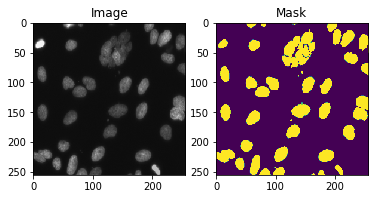

In [4]:
# Plot the images and test
fig = plt.figure()
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(x_images[100])
a.set_title('Image')
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(y_images[100])
a.set_title('Mask')

In [5]:
#%%Tensorflow unet
def get_variable(name,shape):
    return tf.get_variable(name, shape, initializer = tf.contrib.layers.xavier_initializer())

def UNet(X):
    ### Unit 1 ###
    with tf.name_scope('Unit1'):
        W1_1 =   get_variable("W1_1", [3,3,3,16] )
        Z1 = tf.nn.conv2d(X,W1_1, strides = [1,1,1,1], padding = 'SAME')
        A1 = tf.nn.relu(Z1)
        W1_2 =   get_variable("W1_2", [3,3,16,16] )
        Z2 = tf.nn.conv2d(A1,W1_2, strides = [1,1,1,1], padding = 'SAME')
        A2 = tf.nn.relu(Z2) 
        P1 = tf.nn.max_pool(A2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    ### Unit 2 ###
    with tf.name_scope('Unit2'):
        W2_1 =   get_variable("W2_1", [3,3,16,32] )
        Z3 = tf.nn.conv2d(P1,W2_1, strides = [1,1,1,1], padding = 'SAME')
        A3 = tf.nn.relu(Z3)
        W2_2 =   get_variable("W2_2", [3,3,32,32] )
        Z4 = tf.nn.conv2d(A3,W2_2, strides = [1,1,1,1], padding = 'SAME')
        A4 = tf.nn.relu(Z4) 
        P2 = tf.nn.max_pool(A4, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    ### Unit 3 ###
    with tf.name_scope('Unit3'):
        W3_1 =   get_variable("W3_1", [3,3,32,64] )
        Z5 = tf.nn.conv2d(P2,W3_1, strides = [1,1,1,1], padding = 'SAME')
        A5 = tf.nn.relu(Z5)
        W3_2 =   get_variable("W3_2", [3,3,64,64] )
        Z6 = tf.nn.conv2d(A5,W3_2, strides = [1,1,1,1], padding = 'SAME')
        A6 = tf.nn.relu(Z6) 
        P3 = tf.nn.max_pool(A6, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    ### Unit 4 ###
    with tf.name_scope('Unit4'):
        W4_1 =   get_variable("W4_1", [3,3,64,128] )
        Z7 = tf.nn.conv2d(P3,W4_1, strides = [1,1,1,1], padding = 'SAME')
        A7 = tf.nn.relu(Z7)
        W4_2 =   get_variable("W4_2", [3,3,128,128] )
        Z8 = tf.nn.conv2d(A7,W4_2, strides = [1,1,1,1], padding = 'SAME')
        A8 = tf.nn.relu(Z8) 
        P4 = tf.nn.max_pool(A8, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    ### Unit 5 ###
    with tf.name_scope('Unit5'):
        W5_1 =   get_variable("W5_1", [3,3,128,256] )
        Z9 = tf.nn.conv2d(P4,W5_1, strides = [1,1,1,1], padding = 'SAME')
        A9 = tf.nn.relu(Z9)
        W5_2 =   get_variable("W5_2", [3,3,256,256] )
        Z10 = tf.nn.conv2d(A9,W5_2, strides = [1,1,1,1], padding = 'SAME')
        A10 = tf.nn.relu(Z10) 
    ### Unit 6 ###
    with tf.name_scope('Unit6'):
        W6_1 =   get_variable("W6_1", [3,3,256,128] )
        U1 = tf.layers.conv2d_transpose(A10, filters = 128, kernel_size = 2, strides = 2, padding = 'SAME')
        U1 = tf.concat([U1, A8],3)
        W6_2 =   get_variable("W6_2", [3,3,128,128] )
        Z11 = tf.nn.conv2d(U1,W6_1, strides = [1,1,1,1], padding = 'SAME')
        A11 = tf.nn.relu(Z11)
        Z12 = tf.nn.conv2d(A11,W6_2, strides = [1,1,1,1], padding = 'SAME')
        A12 = tf.nn.relu(Z12)
    ### Unit 7 ###
    with tf.name_scope('Unit7'):
        W7_1 =   get_variable("W7_1", [3,3,128,64] )
        U2 = tf.layers.conv2d_transpose(A12, filters = 64, kernel_size = 2, strides = 2, padding = 'SAME')
        U2 = tf.concat([U2, A6],3)
        Z13 = tf.nn.conv2d(U2,W7_1, strides = [1,1,1,1], padding = 'SAME')
        A13 = tf.nn.relu(Z13)
        W7_2 =   get_variable("W7_2", [3,3,64,64] )
        Z14 = tf.nn.conv2d(A13,W7_2, strides = [1,1,1,1], padding = 'SAME')
        A14 = tf.nn.relu(Z14)
    ### Unit 8 ###
    with tf.name_scope('Unit8'):
        W8_1 =   get_variable("W8_1", [3,3,64,32] )
        U3 = tf.layers.conv2d_transpose(A14, filters = 32, kernel_size = 2, strides = 2, padding = 'SAME')
        U3 = tf.concat([U3, A4],3)
        Z15 = tf.nn.conv2d(U3,W8_1, strides = [1,1,1,1], padding = 'SAME')
        A15 = tf.nn.relu(Z15)
        W8_2 =   get_variable("W8_2", [3,3,32,32] )
        Z16 = tf.nn.conv2d(A15,W8_2, strides = [1,1,1,1], padding = 'SAME')
        A16 = tf.nn.relu(Z16)
    ### Unit 9 ###
    with tf.name_scope('Unit9'):
        W9_1 =   get_variable("W9_1", [3,3,32,16] )
        U4 = tf.layers.conv2d_transpose(A16, filters = 16, kernel_size = 2, strides = 2, padding = 'SAME')
        U4 = tf.concat([U4, A2],3)
        Z17 = tf.nn.conv2d(U4,W9_1, strides = [1,1,1,1], padding = 'SAME')
        A17 = tf.nn.relu(Z17)
        W9_2 =   get_variable("W9_2", [3,3,16,16] )
        Z18 = tf.nn.conv2d(A17,W9_2, strides = [1,1,1,1], padding = 'SAME')
        A18 = tf.nn.relu(Z18)
    ### Unit 10 ###
    with tf.name_scope('out_put'):
        W10 =    get_variable("W10", [1,1,16,1] )
        Z19 = tf.nn.conv2d(A18,W10, strides = [1,1,1,1], padding = 'SAME')
        A19 = tf.nn.sigmoid(Z19)
        Y_pred = A19
    return Y_pred

def loss_function(y_pred, y_true):
    cost = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true,y_pred))
    return cost

def mean_iou(y_pred,y_true):
    y_pred_ = tf.to_int64(y_pred > 0.5)
    y_true_ = tf.to_int64(y_true > 0.5)
    score, up_opt = tf.metrics.mean_iou(y_true_, y_pred_, 2)
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    return score
#%%
with tf.device("/gpu:0"):
    x_ = tf.placeholder(tf.float32, shape=(None,IMG_HEIGHT, IMG_WIDTH, 3))
    y_ = tf.placeholder(tf.float32, shape=(None,IMG_HEIGHT, IMG_WIDTH, 1))
    y_pred = UNet(x_)
    loss = loss_function(y_pred,y_)
with tf.device("/cpu:0"):
    iou = mean_iou(y_pred,y_)


In [ ]:
'''
# build the graph as a dictionary
def build_graph():
    with tf.Graph().as_default() as g:
        with tf.device("/gpu:0"):
            with tf.name_scope('input'):
                x_ = tf.placeholder(tf.float32, shape=(None,IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
                y_ = tf.placeholder(tf.float32, shape=(None,IMG_HEIGHT, IMG_WIDTH, 1))
            y_pred = UNet(x_)
            with tf.name_scope('loss'):
                loss = loss_function(y_pred,y_)
        with tf.device("/cpu:0"):
            with tf.name_scope("metrics"):
                iou = mean_iou(y_pred,y_)
        model_dict = {'graph': g, 'inputs': [x_, y_],'Iou':iou,'Loss':loss, 'y_pred':y_pred}
    return model_dict
'''

In [6]:
def get_batch(x,y,batch_size):
    x_tensor=tf.constant(x)
    y_tensor=tf.reshape(y,[-1,IMG_HEIGHT,IMG_WIDTH,1])
    dataset=tf.data.Dataset.from_tensor_slices((x_tensor,y_tensor))
    batched_dataset=dataset.batch(batch_size)
    iterator= batched_dataset.make_one_shot_iterator()
    return iterator

In [7]:
init= tf.global_variables_initializer()

In [8]:
optimizer=tf.train.AdamOptimizer()
train= optimizer.minimize(loss)

In [13]:
graph=tf.get_default_graph()
v= tf.global_variables()
sess=tf.Session()
print sess.run(v)
#for op in graph.get_operations(): print (op.name)

FailedPreconditionError: Attempting to use uninitialized value conv2d_transpose_3/kernel
	 [[Node: conv2d_transpose_3/kernel/_164 = _Send[T=DT_FLOAT, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_332_conv2d_transpose_3/kernel", _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_transpose_3/kernel)]]
	 [[Node: conv2d_transpose_2/kernel/Adam_1/_151 = _Recv[_start_time=0, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_318_conv2d_transpose_2/kernel/Adam_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [9]:
steps=10
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
with tf.Session() as sess:
    sess.run(init)
    
    batched_data=get_batch(x_images,y_images,4)
    
    for i in range(steps):
        batch_x, batch_y= sess.run(batched_data.get_next())
        '''
        print sess.run(tf.shape(batch_x))
        print sess.run(tf.shape(batch_y))
        '''
        sess.run(train,{x_:batch_x,y_:batch_y})
        print('Currently on step {}'.format(i))
        print(sess.run(model['Iou']))

FailedPreconditionError: Attempting to use uninitialized value beta2_power
	 [[Node: beta2_power/read = Identity[T=DT_FLOAT, _class=["loc:@W10"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](beta2_power)]]

Caused by op u'beta2_power/read', defined at:
  File "/home/anandpreshob/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/anandpreshob/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-6b1b25cfe7e7>", line 2, in <module>
    train= optimizer.minimize(loss)
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/optimizer.py", line 353, in minimize
    name=name)
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/optimizer.py", line 474, in apply_gradients
    self._create_slots([_get_variable_for(v) for v in var_list])
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/adam.py", line 133, in _create_slots
    trainable=False)
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 1927, in variable
    caching_device=caching_device, name=name, dtype=dtype)
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 213, in __init__
    constraint=constraint)
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 356, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 125, in identity
    return gen_array_ops.identity(input, name=name)
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2071, in identity
    "Identity", input=input, name=name)
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/anandpreshob/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value beta2_power
	 [[Node: beta2_power/read = Identity[T=DT_FLOAT, _class=["loc:@W10"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](beta2_power)]]
